In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
import gzip

In [2]:
fake_df = pd.read_csv(r"C:\Users\ishik\Downloads\Fake news detection System\Fake (1).csv")
true_df = pd.read_csv(r"C:\Users\ishik\Downloads\Fake news detection System\True (1).csv")

print("Fake shape:", fake_df.shape)
print("True shape:", true_df.shape)
print("\nFake columns:", fake_df.columns.tolist())
print("True columns:", true_df.columns.tolist())

Fake shape: (23481, 4)
True shape: (21417, 4)

Fake columns: ['title', 'text', 'subject', 'date']
True columns: ['title', 'text', 'subject', 'date']


In [3]:
print("=== FAKE NEWS SAMPLE ===")
display(fake_df.head(3))
print("\n=== TRUE NEWS SAMPLE ===")
display(true_df.head(3))

=== FAKE NEWS SAMPLE ===


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"



=== TRUE NEWS SAMPLE ===


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"


In [4]:
def build_text_column(df):
    """
    Build text column by combining title and text if both exist
    """
    text_parts = []
    
    # Check for title/headline
    for col in ['title', 'headline', 'subject']:
        if col in df.columns:
            text_parts.append(df[col].fillna('').astype(str))
            break
    
    # Check for main text/content
    for col in ['text', 'content', 'article']:
        if col in df.columns:
            text_parts.append(df[col].fillna('').astype(str))
            break
    
    if not text_parts:
        raise ValueError("No suitable text columns found!")
    
    # Combine with space
    if len(text_parts) == 1:
        return text_parts[0]
    else:
        return text_parts[0] + ' ' + text_parts[1]

# Build text columns
fake_df['text'] = build_text_column(fake_df)
true_df['text'] = build_text_column(true_df)

# Keep only text column
fake_df = fake_df[['text']].copy()
true_df = true_df[['text']].copy()

# Add labels
fake_df['label'] = 'FAKE'
true_df['label'] = 'TRUE'

print("✅ Text column created")
print(f"Fake samples: {len(fake_df)}")
print(f"True samples: {len(true_df)}")
print(f"\nSample fake text length: {len(fake_df.iloc[0]['text'])} chars")
print(f"Sample true text length: {len(true_df.iloc[0]['text'])} chars")

✅ Text column created
Fake samples: 23481
True samples: 21417

Sample fake text length: 2973 chars
Sample true text length: 4724 chars


In [5]:
# Combine datasets
df = pd.concat([fake_df, true_df], ignore_index=True)

# Remove empty texts
df = df[df['text'].str.strip() != ''].copy()

# Remove duplicates
df = df.drop_duplicates(subset=['text']).copy()

# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Combined shape: {df.shape}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())

# Create numeric labels: TRUE=0, FAKE=1
df['label_num'] = df['label'].map({'TRUE': 0, 'FAKE': 1})

print(f"\nNumeric label distribution:")
print(df['label_num'].value_counts())

# Show sample
print("\n=== SAMPLE DATA ===")
display(df.head())

Combined shape: (39105, 2)

Label distribution:
label
TRUE    21197
FAKE    17908
Name: count, dtype: int64

Numeric label distribution:
label_num
0    21197
1    17908
Name: count, dtype: int64

=== SAMPLE DATA ===


,text,label,label_num
0,Many 'lost' voters say they have found their c...,TRUE,0
1,"Iranian Revolutionary Guards commander, anothe...",TRUE,0
2,Cambodian leader gets China's backing as West ...,TRUE,0
3,Ex-KKK Grand Wizard: Maine Gov. Right To Call...,FAKE,1
4,FINGER-WAGGING GRANNY HILLARY CLINTON Blows Up...,FAKE,1


In [6]:
X = df['text'].values
y = df['label_num'].values

print(f"Total samples: {len(X)}")
print(f"TRUE (0): {np.sum(y==0)} ({np.sum(y==0)/len(y)*100:.1f}%)")
print(f"FAKE (1): {np.sum(y==1)} ({np.sum(y==1)/len(y)*100:.1f}%)")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain size: {len(X_train)}")
print(f"Test size: {len(X_test)}")
print(f"\nTrain labels - TRUE: {np.sum(y_train==0)}, FAKE: {np.sum(y_train==1)}")
print(f"Test labels - TRUE: {np.sum(y_test==0)}, FAKE: {np.sum(y_test==1)}")

Total samples: 39105
TRUE (0): 21197 (54.2%)
FAKE (1): 17908 (45.8%)

Train size: 31284
Test size: 7821

Train labels - TRUE: 16958, FAKE: 14326
Test labels - TRUE: 4239, FAKE: 3582


In [7]:
# Better TF-IDF parameters
tfidf = TfidfVectorizer(
    stop_words='english',
    max_df=0.7,          # Ignore terms in >70% of docs
    min_df=5,            # Ignore terms in <5 docs
    ngram_range=(1, 2),  # Use unigrams AND bigrams
    max_features=5000,   # Keep top 5000 features
    sublinear_tf=True    # Use log scaling
)

tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

print(f"TF-IDF train shape: {tfidf_train.shape}")
print(f"TF-IDF test shape: {tfidf_test.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")

TF-IDF train shape: (31284, 5000)
TF-IDF test shape: (7821, 5000)
Vocabulary size: 5000


In [8]:
# Train with better parameters
clf = PassiveAggressiveClassifier(
    max_iter=50,        # More iterations
    C=0.5,              # Regularization
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5
)

clf.fit(tfidf_train, y_train)
print("✅ Model trained successfully")

✅ Model trained successfully


Accuracy: 0.9955

Classification Report:
              precision    recall  f1-score   support

        TRUE       1.00      1.00      1.00      4239
        FAKE       1.00      0.99      1.00      3582

    accuracy                           1.00      7821
   macro avg       1.00      1.00      1.00      7821
weighted avg       1.00      1.00      1.00      7821



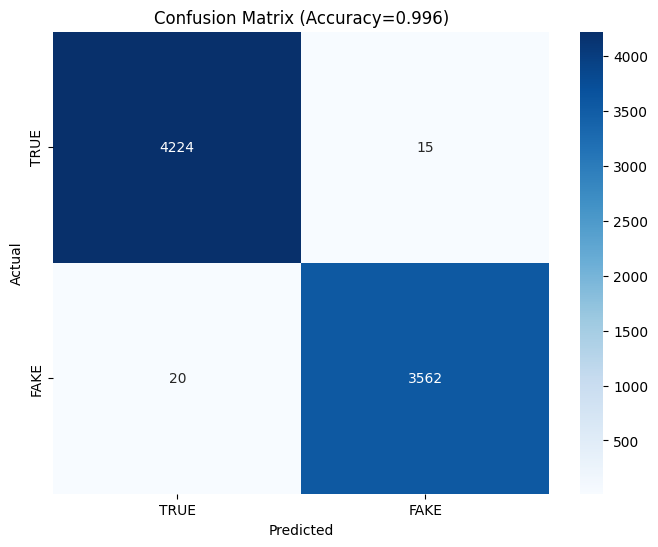


⚠️ Prediction distribution:
Predicted TRUE (0): 4244
Predicted FAKE (1): 3577


In [9]:
y_pred = clf.predict(tfidf_test)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['TRUE', 'FAKE']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['TRUE', 'FAKE'],
            yticklabels=['TRUE', 'FAKE'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Accuracy={acc:.3f})")
plt.show()

# Check if model is biased
print(f"\n⚠️ Prediction distribution:")
print(f"Predicted TRUE (0): {np.sum(y_pred==0)}")
print(f"Predicted FAKE (1): {np.sum(y_pred==1)}")

In [10]:
# Test with diverse samples
test_samples = [
    ("The president announced a new healthcare policy today", "TRUE"),
    ("Scientists at MIT discovered a breakthrough in quantum computing", "TRUE"),
    ("The stock market rose 2% following positive economic data", "TRUE"),
    ("SHOCKING: Celebrities arrested in scandal!!!", "FAKE"),
    ("You won't BELIEVE what happened next!!!", "FAKE"),
    ("BREAKING: Aliens found in Area 51!!!", "FAKE"),
]

print("=== TESTING MODEL ===\n")
correct = 0
for text, expected in test_samples:
    X_sample = tfidf.transform([text])
    pred = clf.predict(X_sample)[0]
    pred_label = "FAKE" if pred == 1 else "TRUE"
    
    match = "✅" if pred_label == expected else "❌"
    correct += (pred_label == expected)
    
    print(f"{match} Text: {text[:60]}")
    print(f"   Expected: {expected}, Got: {pred_label}\n")

print(f"Manual test accuracy: {correct}/{len(test_samples)}")

# If all predictions are the same, there's a problem
unique_preds = len(set([clf.predict(tfidf.transform([t]))[0] for t, _ in test_samples]))
if unique_preds == 1:
    print("\n⚠️ WARNING: Model predicts same class for everything!")
    print("This indicates a training problem.")

=== TESTING MODEL ===

❌ Text: The president announced a new healthcare policy today
   Expected: TRUE, Got: FAKE

❌ Text: Scientists at MIT discovered a breakthrough in quantum compu
   Expected: TRUE, Got: FAKE

✅ Text: The stock market rose 2% following positive economic data
   Expected: TRUE, Got: TRUE

✅ Text: SHOCKING: Celebrities arrested in scandal!!!
   Expected: FAKE, Got: FAKE

✅ Text: You won't BELIEVE what happened next!!!
   Expected: FAKE, Got: FAKE

✅ Text: BREAKING: Aliens found in Area 51!!!
   Expected: FAKE, Got: FAKE

Manual test accuracy: 4/6


In [11]:
# Only save if model passes basic test
test_preds = [clf.predict(tfidf.transform([t]))[0] for t, _ in test_samples]
if len(set(test_preds)) > 1:  # Model makes different predictions
    with gzip.open("model.pkl.gz", "wb") as f:
        pickle.dump(clf, f)
    
    with gzip.open("vectorizer.pkl.gz", "wb") as f:
        pickle.dump(tfidf, f)
    
    print("✅ Model saved successfully")
else:
    print("❌ Model not saved - it's predicting same class for everything!")
    print("Check your data and try again.")

✅ Model saved successfully


In [12]:
# Load and verify
with gzip.open("model.pkl.gz", "rb") as f:
    loaded_model = pickle.load(f)

with gzip.open("vectorizer.pkl.gz", "rb") as f:
    loaded_vec = pickle.load(f)

# Test loaded model
test_text = "The government passed a new education reform bill"
X_test_sample = loaded_vec.transform([test_text])
prediction = loaded_model.predict(X_test_sample)[0]

print(f"Test: {test_text}")
print(f"Prediction: {'FAKE' if prediction==1 else 'TRUE'}")
print("\n✅ Model loaded and tested successfully!")

Test: The government passed a new education reform bill
Prediction: FAKE

✅ Model loaded and tested successfully!
